In [131]:
import pandas as pd
import numpy as np
from PIL import Image
import cv2

import os
import matplotlib.pyplot as plt
# import random
# import shutil

In [132]:
data_dir = os.getcwd() + "/datasets"
train_dir = data_dir + "/train"
val_dir = data_dir + "/val"
test_dir = data_dir +  "/test"

#### Loading each image and their label into an array

In [145]:
def preprocessing(img):
    # common size for images
    IMG_HEIGHT, IMG_WIDTH = 128, 128
    img_array = cv2.imread(img)
    img_resized = cv2.resize(img_array, (IMG_WIDTH, IMG_HEIGHT))
    return img_resized

X = [] # images
y = [] # labels (0 for benign, 1 for malignant)
splits = ['train', 'val', 'test']

def create_arrays(split):
    X = []
    y = []
    if split == 'train':
        img_dir = train_dir
    if split == 'val':
        img_dir = val_dir
    if split == 'test':
        img_dir = test_dir

    classes = ['benign', 'malignant']

    for class_name in classes:
        
        class_dir = os.path.join(img_dir, class_name)
        
        images = [f for f in os.listdir(class_dir) if not f.startswith('.DS_Store')]

        for img in images:
            img = preprocessing(os.path.join(class_dir, img))
            X.append(img)
            if class_name == 'benign':
                y.append(0)
            if class_name == 'malignant':
                y.append(1)

    X = np.array(X)
    y = pd.DataFrame(y, columns=['class_name'])

    return X, y

X_train, y_train = create_arrays('train')
X_val, y_val = create_arrays('val')
X_test, y_test = create_arrays('test')

In [134]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(396, 128, 128, 3)
(108, 128, 128, 3)
(43, 128, 128, 3)


#### Normalize image data

In [146]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

for image in X_train:
    for channel in range(image.shape[2]):
        image[:, :, channel] = ss.fit_transform(image[:, :, channel])
for image in X_val:
    for channel in range(image.shape[2]):
        image[:, :, channel] = ss.transform(image[:, :, channel])
for image in X_test:
    for channel in range(image.shape[2]):
        image[:, :, channel] = ss.transform(image[:, :, channel])    

#### Handle class imbalance

In [147]:
from sklearn.utils import class_weight

y_labels = y_train['class_name'].values
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_labels), y=y_labels)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 0.7071428571428572, 1: 1.706896551724138}


In [148]:
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

#### Model Building

In [149]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D


In [150]:
num_classes = 1 # malignant or not malignant is a binary classification problem

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='sigmoid', name='preds'))

model.summary()

/Users/jenniferjordache/Developer/Kaggle-Breast-Cancer/breast_cancer_venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 124, 124, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 60, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 230400)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │    29,491,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preds (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,547,777 (112.72 MB)

 Trainable params: 29,547,777 (112.72 MB)

 Non-trainable params: 0 (0.00 B)

#### Compile and Train

In [151]:
model.compile(
    # set the loss as binary_crossentropy
    loss=keras.losses.binary_crossentropy,
    # set the optimizer as stochastic gradient descent
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    # set the metric as accuracy
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    y_train,
    epochs=10,
    verbose=1,
    validation_data=(X_val, y_val),
    class_weight=class_weights,
)

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.6384 - loss: 85.6285 - val_accuracy: 0.6111 - val_loss: 0.8546
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.6709 - loss: 0.6625 - val_accuracy: 0.6667 - val_loss: 0.6215
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9038 - loss: 0.3577 - val_accuracy: 0.6759 - val_loss: 0.6980
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9722 - loss: 0.2196 - val_accuracy: 0.6759 - val_loss: 0.7323
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9895 - loss: 0.1076 - val_accuracy: 0.7037 - val_loss: 1.2848
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9968 - loss: 0.0303 - val_accuracy: 0.7130 - val_loss: 1.2896
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 1.0000 - loss: 0.0134 - val_accuracy: 0.7315 - val_loss: 1.3949
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 0.7222 - val_loss

#### Score Model

In [152]:
score = model.evaluate(X_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 2.190911293029785
Test accuracy: 0.7209302186965942


#### Accuracy and Loss Plots

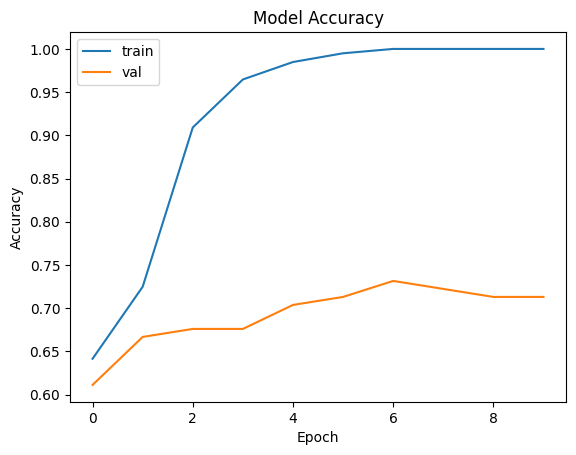

In [153]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

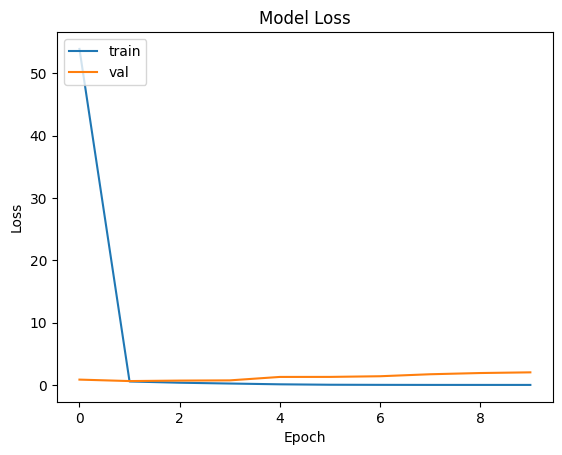

In [154]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Sample Predictions

In [158]:
# predicted probabilities for X_test
proba = model.predict(X_test)

for _ in range(5):
    random_index = np.random.choice(len(proba), replace=False)
    print('Sample from test class')
    print('Prediction probability: ', proba[random_index])
    print('Predicted class: ', np.round(proba[random_index][0]).astype('int'), 'vs. Actual label: ', y_test[random_index][0])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Sample from test class
Prediction probability:  [0.0013323]
Predicted class:  0 vs. Actual label:  0
Sample from test class
Prediction probability:  [0.01121083]
Predicted class:  0 vs. Actual label:  0
Sample from test class
Prediction probability:  [0.79267013]
Predicted class:  1 vs. Actual label:  0
Sample from test class
Prediction probability:  [0.02034885]
Predicted class:  0 vs. Actual label:  0
Sample from test class
Prediction probability:  [0.9849278]
Predicted class:  1 vs. Actual label:  0


#### Helper Functions

In [ ]:
''' Code for moving data into validation folder

validation_split = 0.2  # 20%

classes = ['benign', 'malignant']

for class_name in classes:
    class_train_dir = os.path.join(train_dir, class_name)
    class_val_dir = os.path.join(val_dir, class_name)

    image_files = [f for f in os.listdir(class_train_dir) if os.path.isfile(os.path.join(class_train_dir, f))]

    num_validation_images = int(len(image_files) * validation_split)

    validation_images = random.sample(image_files, num_validation_images)

    for img in validation_images:
        src = os.path.join(class_train_dir, img)
        dst = os.path.join(class_val_dir, img)
        shutil.move(src, dst)

'''